In [1]:
import numpy as np
import astropy.units as u
import time
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
import poppy
import skimage
from skimage.registration import phase_cross_correlation
import copy
from importlib import reload
import matplotlib.pyplot as plt

import magpyx
from magpyx.utils import ImageStream
import purepyindi
from purepyindi import INDIClient
client0 = purepyindi.INDIClient('localhost', 7624)
client0.start()

from math_module import xp, xcipy, np_array
import utils
import fsm_utils
import cam_utils
from imshows import imshow1, imshow2, imshow3
from matplotlib.patches import Circle

wavelength = 633e-9
fl = 450e-3
fsm_pupil_diam = 7.1e-3
as_per_lamD = (wavelength/fsm_pupil_diam*u.radian).to(u.arcsec)
print(as_per_lamD)

pxscl_lamD = 3.45e-6 / (fl * wavelength/fsm_pupil_diam)
print(1/pxscl_lamD)

v_bias = np.array([[50,50,50]]).T



18.389524275269295 arcsec
11.62890385793019


/opt/conda/envs/km310gpu/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [2]:
reload(cam_utils)
cam = cam_utils.CAM('campupil')


In [4]:
npsf = 100
cam.set_roi(530, 890, npsf, client0)

In [10]:
cam.set_exptime(0.0001, client0)

INFO:utils:Got semaphore index 0.


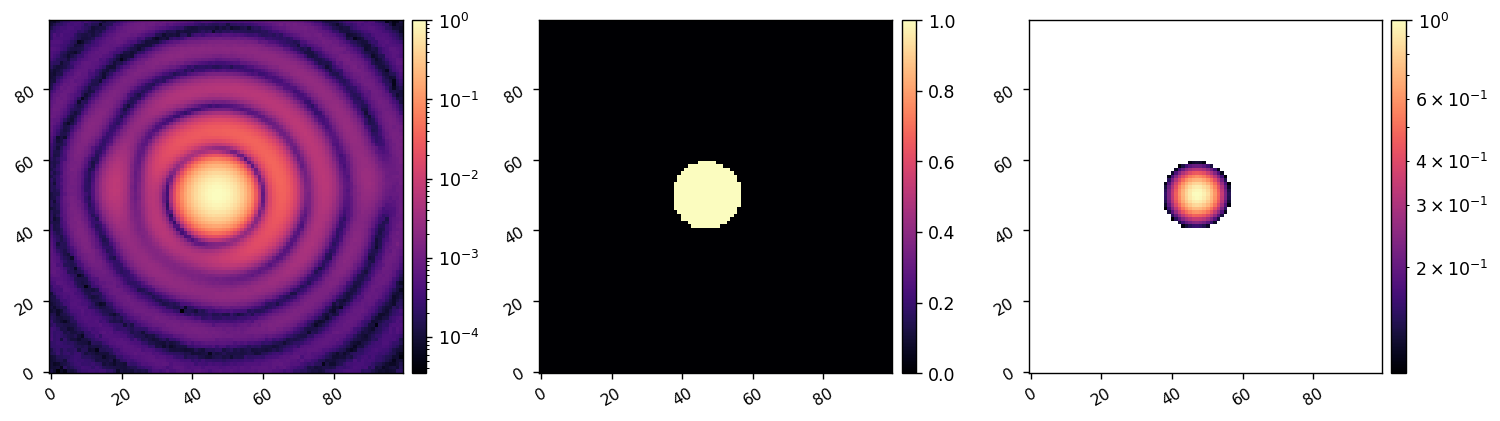

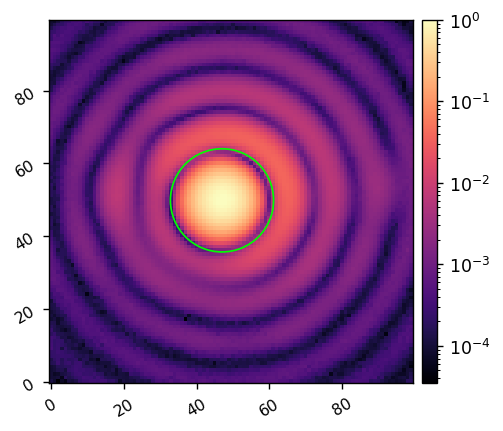

In [3]:
cam.Nframes = 1000
im_bias = cam.snap()

reload(utils)
cen = utils.centroid(im_bias, thresh=0.1, plot=True)
imshow1(im_bias, lognorm=True, patches=[Circle(cen, 1.22/pxscl_lamD, fill=False, color='lime')])


In [13]:
texp = 10

fps = client0[f'campupil.fps.current']
print(fps)

cam.Nframes = texp*fps
print(cam.Nframes)

1245.32995605469
12453.2995605469


In [19]:
start = time.time()
frames = cam.snap_cube()
end = time.time()

In [20]:

freq = 3
fps = client0[f'campupil.fps.current']

hdr = {
    'FPS':fps, 
    'TSTART':start,
    'TEND':end,
}
utils.save_fits(f'data/sin-mod/{today}_fsm_mod_cube_0.5lamD_{freq:04d}.fits', frames, header=hdr)

Saved data to:  data/sin-mod/20241119_fsm_mod_cube_0.5lamD_0003.fits


In [ ]:

start = time.time()
end = start + t_total.to_value(u.s)
count = 0
frames = []
cam.Nframes = Nexp_per_frame
adcs = []
while time.time()<end:
    print(f"Capturing frame {count+1:d}. Time = {time.time()-start:.3f}s", end='')
    print("\r", end="")
    frames.append(cam.snap())
    adcs.append(np.array([client0['fsmCtrl.adc_1.current'], client0['fsmCtrl.adc_2.current'], client0['fsmCtrl.adc_3.current']]))
    count += 1
    time.sleep(1/freq.to_value(u.Hz) - cam.Nframes/fps)

frames = np.array(frames)

data = {
    'AMP':amp, 
    'FRAMES':frames,
    'ADCS':adcs, 
    'FREQ':freq.to_value(u.Hz),
    'EXPTIME':exp_time,
    'NEXPS':Nexp_per_frame, 
    'FPS':fps, 
    'TIME':t_total.to_value(u.s),
}
utils.save_pickle(f'data/drift/{today}_fsm_sin_mod.pkl', data)

[]
[]
nan


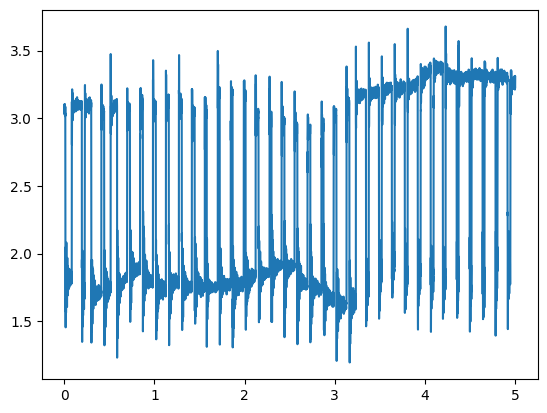

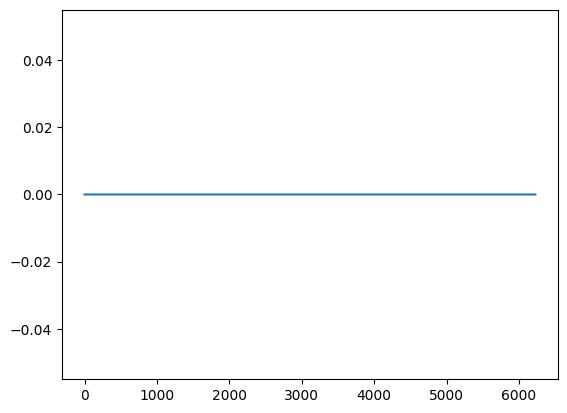

In [8]:
mod_thresh = 5
cents = []
dists = []
for i in range(fsm_cube.shape[0]):
    frame = fsm_cube[i].astype(np.float64)
    cen = utils.centroid(frame, thresh=0.1) - npsf/2
    cents.append(cen)
    dists.append(np.sqrt(cen[0]**2 + cen[1]**2))
cents = np.array(cents)
dists = np.array(dists)

pulse = np.float16(dists>mod_thresh)
est_pulse_length = fps/freq/2

con_ones = []
con_zeros = []
count = 0
for i in range(Nframes-1):
    if pulse[i+1]-pulse[i]!=0:
        if pulse[i]==1:
            con_ones.append(count)
        elif pulse[i]==0:
            con_zeros.append(count)
        count = 0
    count += 1
con_ones = np.array(con_ones)
con_zeros = np.array(con_zeros)

con_ones = con_ones[con_ones>est_pulse_length-50]
con_zeros = con_zeros[con_zeros>est_pulse_length-50]
print(con_ones)
print(con_zeros)

meas_freq = np.mean([fps/np.mean(con_ones)/2, fps/np.mean(con_zeros)/2])
print(meas_freq)

plt.plot(times, dists)
plt.show()
pulse = np.int16(dists>mod_thresh)
plt.plot(pulse)
plt.show()



In [56]:
(7.5-2.5) * pxscl_lamD

0.37061611374407577